### Regression with MLP on waiting times dataset

In [1]:
import numpy as np
import sys
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

sys.path.append('../..')
from Data.datasets.WaitPark import WaitPark

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

Using device: cpu


In [2]:
# Charger les données WaitPark
batch_size = 32
waitpark = WaitPark(batch_size, include_weather=True)
waitpark.print_dataset_info()

# Convert to PyTorch tensors
X_train = torch.FloatTensor(waitpark._input_tensor_train).to(device)
y_train = torch.FloatTensor(waitpark._label_tensor_train).to(device)
X_val = torch.FloatTensor(waitpark._input_tensor_val).to(device)
y_val = torch.FloatTensor(waitpark._label_tensor_val).to(device)
X_test = torch.FloatTensor(waitpark._input_tensor_test).to(device)
y_test = torch.FloatTensor(waitpark._label_tensor_test).to(device)

print(f"📊 Data shapes:")
print(f"   Input features: {X_train.shape[1]}")
print(f"   Train samples: {X_train.shape[0]}")
print(f"   Validation samples: {X_val.shape[0]}")
print(f"   Test samples: {X_test.shape[0]}")


dataset Informations:
--------------------------------------------------
Training samples: 25912
Sample shape: (28,)
Number of classes: 1
Test samples: 5554
Dataset size in memory: 6.72 MB

----------------------------------------------------------------------------------------------------
Train Sample 23654: Unknown - Target Wait Time in 2 Hours: 60.0 minutes
----------------------------------------------------------------------------------------------------

                           DATETIME ENTITY_DESCRIPTION_SHORT ADJUST_CAPACITY       DOWNTIME CURRENT_WAIT_TIME TIME_TO_PARADE_1 TIME_TO_PARADE_2 TIME_TO_NIGHT_SHOW WAIT_TIME_IN_2H           HOUR MINUTE   TIME_MINUTES DAY_OF_WEEK          MONTH          YEAR           DAY        DATE          temp     dew_point    feels_like      pressure       humidity     wind_speed rain_1h snow_1h     clouds_all
Type                                                                                                                                  

### Plusieurs architectures de modèles à tester

In [3]:
class SimpleModel(nn.Module):
    """Simple shallow model with 1 hidden layer"""
    def __init__(self, input_dim, output_dim=1):
        super(SimpleModel, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, output_dim)
        )
        self._init_weights()
    
    def _init_weights(self):
        for layer in self.layers:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)
                nn.init.constant_(layer.bias, 0.0)
    
    def forward(self, x):
        return self.layers(x)
    
    @staticmethod
    def get_config():
        return {'lr': 0.01, 'weight_decay': 0.0001}

class DeepModel(nn.Module):
    """Deep model with 4 hidden layers"""
    def __init__(self, input_dim, output_dim=1):
        super(DeepModel, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, output_dim)
        )
        self._init_weights()
    
    def _init_weights(self):
        for layer in self.layers:
            if isinstance(layer, nn.Linear):
                nn.init.kaiming_uniform_(layer.weight, nonlinearity='relu')
                nn.init.constant_(layer.bias, 0.1)
    
    def forward(self, x):
        return self.layers(x)
    
    @staticmethod
    def get_config():
        return {'lr': 0.0005, 'weight_decay': 0.01}

class DropoutModel(nn.Module):
    """Model with dropout for regularization"""
    def __init__(self, input_dim, output_dim=1):
        super(DropoutModel, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(32, output_dim)
        )
        self._init_weights()
    
    def _init_weights(self):
        for layer in self.layers:
            if isinstance(layer, nn.Linear):
                nn.init.kaiming_uniform_(layer.weight, nonlinearity='relu')
                nn.init.constant_(layer.bias, 0.1)
    
    def forward(self, x):
        return self.layers(x)
    
    @staticmethod
    def get_config():
        return {'lr': 0.001, 'weight_decay': 0.005}

class LeakyReLUModel(nn.Module):
    """Model with LeakyReLU activation"""
    def __init__(self, input_dim, output_dim=1):
        super(LeakyReLUModel, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.LeakyReLU(0.01),
            nn.Linear(128, 64),
            nn.LeakyReLU(0.01),
            nn.Linear(64, output_dim)
        )
        self._init_weights()
    
    def _init_weights(self):
        for layer in self.layers:
            if isinstance(layer, nn.Linear):
                nn.init.kaiming_uniform_(layer.weight, nonlinearity='leaky_relu')
                nn.init.constant_(layer.bias, 0.1)
    
    def forward(self, x):
        return self.layers(x)
    
    @staticmethod
    def get_config():
        return {'lr': 0.001, 'weight_decay': 0.001}

In [4]:
def calculate_metrics(predictions, targets):
    """Calculate regression metrics"""
    if torch.is_tensor(predictions):
        predictions = predictions.detach().cpu().numpy()
    if torch.is_tensor(targets):
        targets = targets.detach().cpu().numpy()
    
    predictions = predictions.flatten()
    targets = targets.flatten()
    
    mse = mean_squared_error(targets, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(targets, predictions)
    r2 = r2_score(targets, predictions)
    
    return {'mse': mse, 'rmse': rmse, 'mae': mae, 'r2': r2}

def train_model(model, X_train, y_train, X_val, y_val, epochs=1000, batch_size=32):
    """Train a PyTorch model"""
    config = model.get_config()
    optimizer = optim.Adam(model.parameters(), lr=config['lr'], weight_decay=config['weight_decay'])
    criterion = nn.MSELoss()
    
    # Data loaders
    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    # Training history
    history = {'epochs': [], 'train_loss': [], 'val_loss': [], 'val_r2': []}
    
    model.train()
    for epoch in range(epochs):
        epoch_loss = 0.0
        num_batches = 0
        
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            num_batches += 1
        
        # Log metrics every 100 epochs
        if epoch % 100 == 0 or epoch == epochs - 1:
            model.eval()
            with torch.no_grad():
                train_pred = model(X_train)
                val_pred = model(X_val)
                
                train_loss = criterion(train_pred, y_train).item()
                val_loss = criterion(val_pred, y_val).item()
                val_metrics = calculate_metrics(val_pred, y_val)
                
                history['epochs'].append(epoch)
                history['train_loss'].append(train_loss)
                history['val_loss'].append(val_loss)
                history['val_r2'].append(val_metrics['r2'])
                
                if epoch % 200 == 0:
                    print(f"Epoch {epoch:4d} | Train Loss: {train_loss:.4f} | "
                          f"Val Loss: {val_loss:.4f} | Val R²: {val_metrics['r2']:.4f}")
            
            model.train()
    
    return history

def evaluate_model(model, X_test, y_test):
    """Evaluate model on test set"""
    model.eval()
    with torch.no_grad():
        test_pred = model(X_test)
        metrics = calculate_metrics(test_pred, y_test)
    return test_pred, metrics

def plot_results(y_true, y_pred, title="Model Results"):
    """Plot prediction results"""
    if torch.is_tensor(y_true):
        y_true = y_true.detach().cpu().numpy().flatten()
    if torch.is_tensor(y_pred):
        y_pred = y_pred.detach().cpu().numpy().flatten()
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Predictions vs Reality
    axes[0].scatter(y_true, y_pred, alpha=0.6, s=30)
    max_val = max(y_true.max(), y_pred.max())
    axes[0].plot([0, max_val], [0, max_val], 'r--', linewidth=2)
    axes[0].set_xlabel('Real waiting time (min)')
    axes[0].set_ylabel('Predicted waiting time (min)')
    axes[0].set_title(f'{title} - Predictions vs Reality')
    axes[0].grid(True, alpha=0.3)
    
    # Error distribution
    errors = y_pred - y_true
    axes[1].hist(errors, bins=30, alpha=0.7, edgecolor='black')
    axes[1].axvline(errors.mean(), color='red', linestyle='--', 
                   label=f'Mean: {errors.mean():.2f}')
    axes[1].set_xlabel('Prediction error (min)')
    axes[1].set_ylabel('Frequency')
    axes[1].set_title(f'{title} - Error Distribution')
    axes[1].grid(True, alpha=0.3)
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()

def compare_models(models_dict, X_train, y_train, X_val, y_val, X_test, y_test, epochs=1000):
    """Compare multiple models"""
    results = {}
    
    print("🚀 TRAINING AND COMPARING MODELS")
    print("=" * 60)
    
    for name, model_class in models_dict.items():
        print(f"\n📊 Training {name}...")
        
        # Create and train model
        model = model_class(input_dim=X_train.shape[1]).to(device)
        history = train_model(model, X_train, y_train, X_val, y_val, epochs=epochs)
        
        # Evaluate on test set
        test_pred, test_metrics = evaluate_model(model, X_test, y_test)
        
        results[name] = {
            'model': model,
            'history': history,
            'test_metrics': test_metrics,
            'test_predictions': test_pred
        }
        
        print(f"✅ {name} - Test R²: {test_metrics['r2']:.4f}, RMSE: {test_metrics['rmse']:.4f}")
    
    # Print comparison table
    print(f"\n{'=' * 60}")
    print("📊 FINAL COMPARISON")
    print(f"{'=' * 60}")
    print(f"{'Model':<20} {'RMSE':<10} {'MAE':<10} {'R²':<10}")
    print("-" * 60)
    
    for name, result in results.items():
        metrics = result['test_metrics']
        print(f"{name:<20} {metrics['rmse']:<10.4f} {metrics['mae']:<10.4f} {metrics['r2']:<10.4f}")
    
    # Find best model
    best_model_name = max(results.keys(), key=lambda k: results[k]['test_metrics']['r2'])
    best_result = results[best_model_name]
    
    print(f"\n🏆 Best model: {best_model_name}")
    print(f"   R² = {best_result['test_metrics']['r2']:.4f}")
    print(f"   RMSE = {best_result['test_metrics']['rmse']:.4f}")
    
    # Plot best model results
    plot_results(y_test, best_result['test_predictions'], f"Best Model: {best_model_name}")
    
    return results, best_model_name

🚀 TRAINING AND COMPARING MODELS

📊 Training Simple...
Epoch    0 | Train Loss: 95.0805 | Val Loss: 97.4963 | Val R²: 0.5233
✅ Simple - Test R²: 0.5296, RMSE: 9.6986

📊 Training Deep...
Epoch    0 | Train Loss: 91.3776 | Val Loss: 95.2650 | Val R²: 0.5342
✅ Deep - Test R²: 0.5391, RMSE: 9.6007

📊 Training Dropout...
Epoch    0 | Train Loss: 101.9107 | Val Loss: 104.5747 | Val R²: 0.4887
✅ Dropout - Test R²: 0.4933, RMSE: 10.0666

📊 Training LeakyReLU...
Epoch    0 | Train Loss: 98.2539 | Val Loss: 101.3656 | Val R²: 0.5044
✅ LeakyReLU - Test R²: 0.5085, RMSE: 9.9141

📊 FINAL COMPARISON
Model                RMSE       MAE        R²        
------------------------------------------------------------
Simple               9.6986     7.3342     0.5296    
Deep                 9.6007     7.1945     0.5391    
Dropout              10.0666    7.6068     0.4933    
LeakyReLU            9.9141     7.4920     0.5085    

🏆 Best model: Deep
   R² = 0.5391
   RMSE = 9.6007


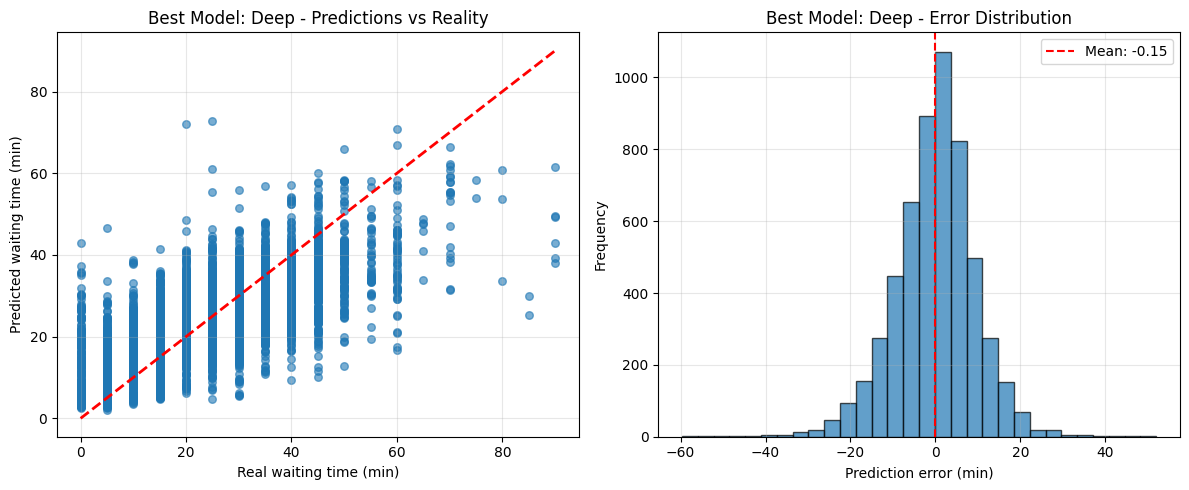

In [5]:
# Define models to compare
models_to_test = {
    'Simple': SimpleModel,
    'Deep': DeepModel,
    'Dropout': DropoutModel,
    'LeakyReLU': LeakyReLUModel
}

# Train and compare models
results, best_model_name = compare_models(
    models_to_test, X_train, y_train, X_val, y_val, X_test, y_test, 
    epochs=1
)